In [182]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFdr
from scipy.stats import chi2

In [2]:
# colors
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
    
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [3]:
X_all = data[data_cols].T
X_only_conv = data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T


y_3class = fg.set_index('combined_col_name')['glucose_tolerance']         # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg.set_index('combined_col_name')['bg']                            # random/fasted blood glucoose
ogtt_dict = animal_phenotypes.set_index('animal').to_dict()['OGTT (AUC)'] # OGTT AUC
y_ogtt = fg[['combined_col_name', 'animal']].set_index('combined_col_name')['animal'].map(ogtt_dict)  

In [265]:
# Make data for Statsmodels function API
feature_cols = X_all.columns
lmdata = X_all.join(fg.set_index('combined_col_name')[['bg_type', 'bg', 'week']]).join(y_ogtt).rename({'animal': 'ogtt'}, axis=1)
lmdata

,l_0,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,m_557,m_169,m_213,m_24,m_505,m_441,bg_type,bg,week,ogtt
1076_10_FBG,20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,19.856909,24.882649,20.930852,27.101820,20.783983,22.129900,FBG,71.000000,10,2321.25
1062_8_FBG,23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.968729,24.605962,21.303302,27.465801,21.295813,22.281020,FBG,52.333333,8,1648.75
1093_9_FBG,23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,20.559004,25.488336,19.581065,26.936184,19.838921,21.851189,FBG,64.000000,9,993.00
1060_8_RBG,24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,20.708589,24.568105,23.318774,27.795283,21.858665,22.537343,RBG,225.000000,8,1761.75
1091_10_FBG,24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.440626,24.949127,19.437282,27.044044,20.366726,21.887095,FBG,48.500000,10,846.75
1092_9_RBG,23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,21.073392,25.119634,23.268904,27.561589,21.397133,22.607897,RBG,70.500000,9,1377.95
1093_10_RBG,23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,21.153981,25.008021,23.345351,27.863524,21.742171,22.614663,RBG,69.500000,10,993.00
1082_10_FBG,23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,20.243994,24.852314,22.052052,27.438797,21.247307,22.346741,FBG,50.000000,10,2224.75
1060_9_RBG,24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,20.482364,25.064357,17.810755,26.430616,18.004667,22.303816,RBG,83.000000,9,1761.75
1101_9_FBG,23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,20.504512,24.826840,19.078979,26.924145,20.352671,21.932740,FBG,43.000000,9,2015.75


In [133]:
def get_model_params(feature_name,
                     value_type,
                     full_model,
                     no_gluc_tol_model,
                     no_feeding_model,
                     no_cross_model):
    d = {}
    d['feature_name'] = feature_name
    
    d['gluc_pval'] =     full_model.compare_lr_test(no_gluc_tol_model)[1]
    d['sampling_pval'] = full_model.compare_lr_test(no_feeding_model)[1]  
    d['cross_pval'] =    full_model.compare_lr_test(no_cross_model)[1]  
    d['fdr_gluc_qval'] = np.nan
    d['fdr_sampling_qval'] = np.nan
    d['fdr_cross_qval'] = np.nan
    
#     d['full_model_converged'] = full_model.converged
#     d['no_gluc_tol_converged'] = no_gluc_tol_model.converged
#     d['no_feeding_converged'] = no_feeding_model.converged
#     d['no_cross_converged'] = no_cross_model.converged
    
    d['full_model_ll'] = full_model.llf
    d['no_gluc_tol_ll'] = no_gluc_tol_model.llf
    d['no_feeding_ll'] = no_feeding_model.llf
    d['no_cross_ll'] = no_cross_model.llf
    
    d['full_model_params'] = full_model.params.to_dict()
    d['no_gluc_tol_params'] = no_gluc_tol_model.params.to_dict()
    d['no_feeding_params'] = no_feeding_model.params.to_dict()
    d['no_cross_params'] = no_cross_model.params.to_dict()
    
    return d
#     lrt = 2*(full_model.llf - model.llf) 
#     p_val = chi2.sf(lrt, 1)   # chi-squared Survival Function (gives integral under distribution above value)
#     d['p_val'] =    p_val
#     d['0.05_signif'] = (True if p_val < 0.05 else False)

In [134]:
def fit_models(features):
    ogtt_result = []
    for feature in features:
        full =       smf.ols(f'{feature} ~ ogtt * bg_type', data=lmdata).fit()
        no_ogtt =    smf.ols(f'{feature} ~        bg_type', data=lmdata).fit()
        no_feeding = smf.ols(f'{feature} ~ ogtt          ', data=lmdata).fit()
        no_cross =   smf.ols(f'{feature} ~ ogtt + bg_type', data=lmdata).fit()
        
        ogtt_result.append(get_model_params(feature_name=feature,
                                            value_type='ogtt',
                                            full_model=full,
                                            no_gluc_tol_model=no_ogtt,
                                            no_feeding_model=no_feeding,
                                            no_cross_model=no_cross))
    bg_result = []
    for feature in features:
        full =       smf.ols(f'{feature} ~ bg * bg_type', data=lmdata).fit()
        no_ogtt =    smf.ols(f'{feature} ~      bg_type', data=lmdata).fit()
        no_feeding = smf.ols(f'{feature} ~ bg          ', data=lmdata).fit()
        no_cross =   smf.ols(f'{feature} ~ bg + bg_type', data=lmdata).fit()

        bg_result.append(get_model_params(feature_name=feature,
                                          value_type='bg',
                                            full_model=full,
                                            no_gluc_tol_model=no_ogtt,
                                            no_feeding_model=no_feeding,
                                            no_cross_model=no_cross))
    return ogtt_result, bg_result

In [132]:
import random
feature = random.sample(list(feature_cols), 1)[0]
print(feature)
test = smf.ols(f'{feature} ~ ogtt * bg_type', data=lmdata).fit()
test_r1 = smf.ols(f'{feature} ~     bg_type', data=lmdata).fit()
test_r2 = smf.ols(f'{feature} ~ ogtt       ', data=lmdata).fit()
test_r3 = smf.ols(f'{feature} ~ ogtt + bg_type', data=lmdata).fit()

print('test statistic,        p-value,           difference in df')
print(test.compare_lr_test(test_r1))
print(test.compare_lr_test(test_r2))
print(test.compare_lr_test(test_r3))

m_303
test statistic,        p-value,           difference in df
(6.084196248972262, 0.04773463115527627, 2.0)
(98.39917825613148, 4.294275762435037e-22, 2.0)
(3.4717976606029453, 0.06242343710903523, 1.0)


In [135]:
test = smf.ols(f'l_555 ~ bg * bg_type', data=lmdata).fit()
display(test.cov_params())
display(test.conf_int())

,Intercept,bg_type[T.RBG],bg,bg:bg_type[T.RBG]
Intercept,0.037186,-0.037186,-0.000487,0.000487
bg_type[T.RBG],-0.037186,0.074236,0.000487,-0.000621
bg,-0.000487,0.000487,0.000008,-0.000008
bg:bg_type[T.RBG],0.000487,-0.000621,-0.000008,0.000009


,0,1
Intercept,18.750960,19.523552
bg_type[T.RBG],0.494376,1.585997
bg,-0.005920,0.005517
bg:bg_type[T.RBG],-0.005688,0.006179


In [136]:
result = fit_models(feature_cols)

In [209]:
ogtt = pd.DataFrame(result[0]).set_index('feature_name')
bg = pd.DataFrame(result[1]).set_index('feature_name')
ogtt

,gluc_pval,sampling_pval,cross_pval,fdr_gluc_qval,fdr_sampling_qval,fdr_cross_qval,full_model_ll,no_gluc_tol_ll,no_feeding_ll,no_cross_ll,full_model_params,no_gluc_tol_params,no_feeding_params,no_cross_params
feature_name,,,,,,,,,,,,,,
l_0,0.341121,3.670408e-02,0.822562,NaN,NaN,NaN,-50.703556,-51.779073,-54.008423,-50.728700,"{'Intercept': 23.67567725361177, 'bg_type[T.RB...","{'Intercept': 23.24699628316563, 'bg_type[T.RB...","{'Intercept': 23.810235575407763, 'ogtt': -0.0...","{'Intercept': 23.6186842260093, 'bg_type[T.RBG..."
l_1,0.593557,9.025863e-01,0.684049,NaN,NaN,NaN,-72.113038,-72.634661,-72.215529,-72.195840,"{'Intercept': 24.670772845133506, 'bg_type[T.R...","{'Intercept': 24.476783695839988, 'bg_type[T.R...","{'Intercept': 24.839267002225867, 'ogtt': -0.0...","{'Intercept': 24.81861527245705, 'bg_type[T.RB..."
l_2,0.676955,2.880545e-01,0.518138,NaN,NaN,NaN,-58.680346,-59.070496,-59.924952,-58.889145,"{'Intercept': 23.618616065261367, 'bg_type[T.R...","{'Intercept': 23.60640305021915, 'bg_type[T.RB...","{'Intercept': 23.55175999673154, 'ogtt': 0.000...","{'Intercept': 23.43074061299636, 'bg_type[T.RB..."
l_3,0.437841,1.141631e-01,0.506729,NaN,NaN,NaN,-44.849866,-45.675765,-47.019994,-45.070274,"{'Intercept': 27.267338988868747, 'bg_type[T.R...","{'Intercept': 26.85818465005638, 'bg_type[T.RB...","{'Intercept': 27.246931101792473, 'ogtt': -0.0...","{'Intercept': 27.114034990066614, 'bg_type[T.R..."
l_4,0.512260,6.257205e-02,0.251348,NaN,NaN,NaN,-59.173591,-59.842514,-61.945027,-59.831488,"{'Intercept': 22.73239618202266, 'bg_type[T.RB...","{'Intercept': 22.438824645125887, 'bg_type[T.R...","{'Intercept': 22.572092640593894, 'ogtt': 2.69...","{'Intercept': 22.39488757084885, 'bg_type[T.RB..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,0.000136,1.912550e-01,0.843401,NaN,NaN,NaN,18.840335,9.938298,17.186188,18.820823,"{'Intercept': 25.24574049909552, 'bg_type[T.RB...","{'Intercept': 24.898844984376986, 'bg_type[T.R...","{'Intercept': 25.303336623618655, 'ogtt': -0.0...","{'Intercept': 25.26149333526538, 'bg_type[T.RB..."
m_213,0.638285,2.441476e-04,0.836622,NaN,NaN,NaN,-121.868945,-122.317916,-130.186682,-121.890207,"{'Intercept': 21.072754787526677, 'bg_type[T.R...","{'Intercept': 20.12865195340113, 'bg_type[T.RB...","{'Intercept': 21.942605387044438, 'ogtt': -0.0...","{'Intercept': 20.90115826615619, 'bg_type[T.RB..."
m_24,0.297445,3.718213e-04,0.332515,NaN,NaN,NaN,-40.549320,-41.761846,-48.446417,-41.018859,"{'Intercept': 27.516619949020836, 'bg_type[T.R...","{'Intercept': 27.042691925697746, 'bg_type[T.R...","{'Intercept': 27.561983213596037, 'ogtt': -0.0...","{'Intercept': 27.307906307536467, 'bg_type[T.R..."


In [213]:
for df in [ogtt, bg]:
    for pval, qval in zip(df.filter(regex='pval').columns, df.filter(regex='qval').columns):
        df.loc[:, qval] = fdrcorrection(df[pval])[1]

gluc_pval fdr_gluc_qval 

sampling_pval fdr_sampling_qval 

cross_pval fdr_cross_qval 

gluc_pval fdr_gluc_qval 

sampling_pval fdr_sampling_qval 

cross_pval fdr_cross_qval 



In [212]:
# Save to files
ogtt.to_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv')
bg.to_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv')

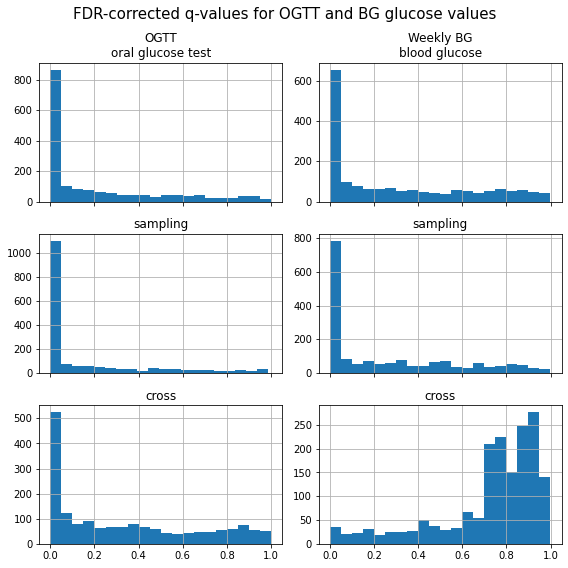

In [172]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8), sharex=True)

ogtt['fdr_gluc_qval'].hist(bins=20, ax=ax1)
ax1.set_title('OGTT\noral glucose test')
ogtt['fdr_sampling_qval'].hist(bins=20, ax=ax3)
ax3.set_title('sampling')
ogtt['fdr_cross_qval'].hist(bins=20, ax=ax5)
ax5.set_title('cross')

bg['fdr_gluc_qval'].hist(bins=20, ax=ax2)
ax2.set_title('Weekly BG\nblood glucose')
bg['fdr_sampling_qval'].hist(bins=20, ax=ax4)
ax4.set_title('sampling')
bg['fdr_cross_qval'].hist(bins=20, ax=ax6)
ax6.set_title('cross')

fig.suptitle('FDR-corrected q-values for OGTT and BG glucose values', fontsize=15)
plt.tight_layout()

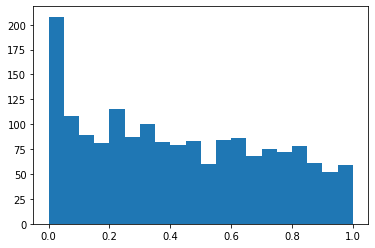

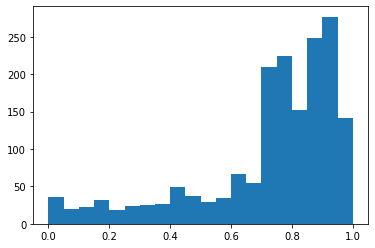

In [206]:
plt.hist(bg['cross_pval'], bins=20)
plt.figure()
plt.hist(bg['fdr_cross_qval'], bins=20);

# What is the overlap of features significant between both OGTT and Weekly BG for glucose tolerance? 

In [244]:
print(len(ogtt_gluc_signif.symmetric_difference(bg_gluc_signif)), 'features not in both')

395 features not in both


In [245]:
print(len(ogtt_gluc_signif.intersection(bg_gluc_signif)), 'features in both')

562 features in both


Text(0, 0.5, 'Weekly BG log q-value')

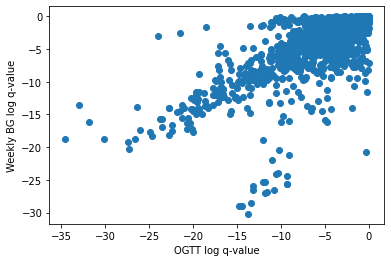

In [223]:
plt.scatter(np.log(ogtt['fdr_gluc_qval']), np.log(bg['fdr_gluc_qval']))
plt.xlabel('OGTT log q-value')
plt.ylabel('Weekly BG log q-value')

Index(['l_29', 'l_43', 'l_45', 'l_47', 'l_55', 'l_56', 'l_58', 'l_59', 'l_60',
       'l_67',
       ...
       'm_247', 'm_432', 'm_122', 'm_226', 'm_90', 'm_368', 'm_340', 'm_616',
       'm_557', 'm_169'],
      dtype='object', name='feature_name', length=957)

Text(0.5, 1.0, 'Showing only features significant in either model')

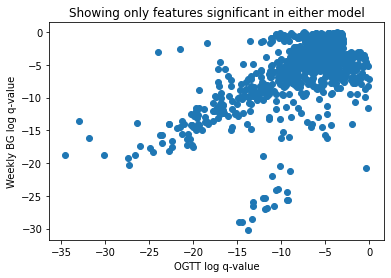

In [264]:
either_signif = ogtt[(ogtt['fdr_gluc_qval'] < 0.05) | (bg['fdr_gluc_qval'] < 0.05)].index
display(either_signif)
plt.scatter(np.log(ogtt.loc[either_signif, 'fdr_gluc_qval']), 
            np.log(bg.loc[either_signif, 'fdr_gluc_qval']))
plt.xlabel('OGTT log q-value')
plt.ylabel('Weekly BG log q-value')
plt.title('Showing only features significant in either model')

In [229]:
ogtt_gluc_signif = set(ogtt.loc[ogtt['fdr_gluc_qval'] < 0.05, 'fdr_gluc_qval'].index)
bg_gluc_signif = set(bg.loc[bg['fdr_gluc_qval'] < 0.05, 'fdr_gluc_qval'].index)

In [242]:
set([1,2,3]).intersection(set([2]))

{2}

In [240]:
set([2]).symmetric_difference(set([1,2,3]))

{1, 3}

# What is the effect of incorporating time into ogtt fixed effects model? 

In [ ]:
def fit_models(features):
    ogtt_result = []
    for feature in features:
        full =       smf.ols(f'{feature} ~ ogtt * bg_type', data=lmdata).fit()
        no_ogtt =    smf.ols(f'{feature} ~        bg_type', data=lmdata).fit()
        no_feeding = smf.ols(f'{feature} ~ ogtt          ', data=lmdata).fit()
        no_cross =   smf.ols(f'{feature} ~ ogtt + bg_type', data=lmdata).fit()
        
        ogtt_result.append(get_model_params(feature_name=feature,
                                            value_type='ogtt',
                                            full_model=full,
                                            no_gluc_tol_model=no_ogtt,
                                            no_feeding_model=no_feeding,
                                            no_cross_model=no_cross))
    bg_result = []
    for feature in features:
        full =       smf.ols(f'{feature} ~ bg * bg_type', data=lmdata).fit()
        no_ogtt =    smf.ols(f'{feature} ~      bg_type', data=lmdata).fit()
        no_feeding = smf.ols(f'{feature} ~ bg          ', data=lmdata).fit()
        no_cross =   smf.ols(f'{feature} ~ bg + bg_type', data=lmdata).fit()

        bg_result.append(get_model_params(feature_name=feature,
                                          value_type='bg',
                                            full_model=full,
                                            no_gluc_tol_model=no_ogtt,
                                            no_feeding_model=no_feeding,
                                            no_cross_model=no_cross))
    return ogtt_result, bg_result

In [266]:
lmdata

,l_0,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,m_557,m_169,m_213,m_24,m_505,m_441,bg_type,bg,week,ogtt
1076_10_FBG,20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,19.856909,24.882649,20.930852,27.101820,20.783983,22.129900,FBG,71.000000,10,2321.25
1062_8_FBG,23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.968729,24.605962,21.303302,27.465801,21.295813,22.281020,FBG,52.333333,8,1648.75
1093_9_FBG,23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,20.559004,25.488336,19.581065,26.936184,19.838921,21.851189,FBG,64.000000,9,993.00
1060_8_RBG,24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,20.708589,24.568105,23.318774,27.795283,21.858665,22.537343,RBG,225.000000,8,1761.75
1091_10_FBG,24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.440626,24.949127,19.437282,27.044044,20.366726,21.887095,FBG,48.500000,10,846.75
1092_9_RBG,23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,21.073392,25.119634,23.268904,27.561589,21.397133,22.607897,RBG,70.500000,9,1377.95
1093_10_RBG,23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,21.153981,25.008021,23.345351,27.863524,21.742171,22.614663,RBG,69.500000,10,993.00
1082_10_FBG,23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,20.243994,24.852314,22.052052,27.438797,21.247307,22.346741,FBG,50.000000,10,2224.75
1060_9_RBG,24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,20.482364,25.064357,17.810755,26.430616,18.004667,22.303816,RBG,83.000000,9,1761.75
1101_9_FBG,23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,20.504512,24.826840,19.078979,26.924145,20.352671,21.932740,FBG,43.000000,9,2015.75


In [281]:
ogtt_time_result = []
for feature in feature_cols:
    full = smf.ols(f'{feature} ~ (ogtt * bg_type) + week', data=lmdata).fit()
    no_time = smf.ols(f'{feature} ~ ogtt * bg_type', data=lmdata).fit()
    
    ogtt_time_result.append({'feature': feature, 'time_pval': full.compare_lr_test(no_time)[1]})

In [283]:
time_result = pd.DataFrame(ogtt_time_result)
time_result

,feature,time_pval
0,l_0,0.276245
1,l_1,0.897049
2,l_2,0.197006
3,l_3,0.073913
4,l_4,0.486627
...,...,...
1722,m_169,0.650903
1723,m_213,0.643224
1724,m_24,0.858481
1725,m_505,0.870860


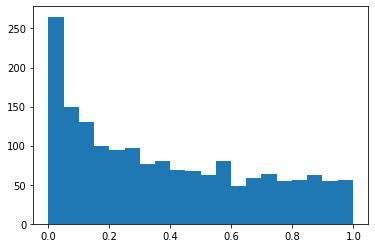

In [290]:
plt.hist(time_result['time_pval'], bins=20);

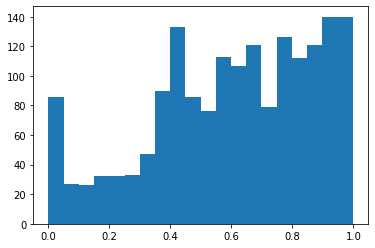

In [291]:
plt.hist(fdrcorrection(time_result['time_pval'])[1], bins=20);

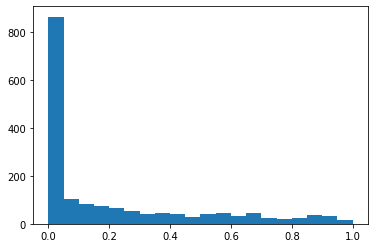

In [294]:
plt.hist(ogtt['fdr_gluc_qval'], bins=20);